# Vectorization of computations

Vectorization is basically the art of getting rid of explicit `for` loops in your code. In the deep learning era, you often find yourself training on relatively large data sets, because that's where deep learning algorithms tend to shine. And so, it's important that your code computes very quickly because otherwise, if it's running on a big data set, your code might take a long time to complete.

Let's illustrate how the vectorization of computations can have a dramatic effect on computational speed. This affects would be even more dramatic if you were using a GPU.

Let's create 2 large arrays, `a` and `b` containing random numbers to illustrate the performance benefits of carrying out linear algebra operations in vectorized form. 

In [4]:
import random
import numpy as np
import time

a = np.random.rand(100000000)
b = np.random.rand(100000000)

Our test will to compute the dot product between `a` and `b` and store the scalar result in c. 

First, we calculate the dot product using a `for` loop and monitor the time it takes to complete (it should take between 30 seconds and 1 minute to complete depending on your CPU characteristics)

In [5]:
c=0
tic = time.time() # Start timing
for i in range(len(a)):
    c = c+a[i]*b[i]
toc = time.time()   # End timing
print("Result of the computation (Dot product between a and b):" +str(c))
print("Computing time of the for loop version:" +str(1000*(toc-tic))+" ms")

Result of the computation (Dot product between a and b):25001180.352278873
Computing time of the for loop version:58419.34156417847 ms


Let's now try a vectorized implementation of the vector dot product using the `numpy` Library.

In [6]:
c=0
tic = time.time() # Start timing
c = np.dot(a,b)
toc = time.time()   # End timing
print("Result of the computation (Dot product between a and b):" +str(c))
print("Computing time of the vectorized version:" +str(1000*(toc-tic))+" ms")

Result of the computation (Dot product between a and b):25001180.352277514
Computing time of the vectorized version:118.00670623779297 ms


As you can see, the vectorized implementation of the computation is anywhere between 200 and 400 times faster to complete. If you were to use a GPU for carrying out the dot product, you would get another 100 factor improvement in computation time.

Keras and tensorflow allow installation on GPU mode to speed up the training of large models but I think for the scope of this course, that would be complicated since not everyone in the class has a decent Nvidia GPU. Therefore, CPU computation should suffice.

# Installing Keras

Before installing Keras, please install one of its backend engines: TensorFlow, Theano, or CNTK. 

[TensorFlow installation instructions](https://www.tensorflow.org/install/)

Then, you can install Keras itself. 

[Keras Installation instructions](https://keras.io/#installation)

TensorFlow and Keras are already installed in the classroom computers.

# A first look at a Keras neural network

We will now take a look at a first concrete example of a neural network in Keras using the familiar example of classifying hand-written digits (MNIST Digits data set). However, using Keras hopefully you will notice that this TensorFlow wrapper simplifies the code a lot in comparison to using raw tensorflow. 


The problem we are trying to solve is to classify grayscale images of handwritten digits (28 pixels by 28 pixels), into their 10 
categories (0 to 9). The dataset we will use is the MNIST dataset, a classic dataset in the machine learning community, which has been around for almost as long as the field itself and has been very intensively studied. It's a set of 60,000 training images, plus 10,000 test images, assembled by the National Institute of Standards and Technology (the NIST in MNIST) in the 1980s. You can think of "solving" MNIST as the "Hello World" of deep learning -- it's what you do to verify that your algorithms are working as expected. 

In [7]:
import keras
keras.__version__

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

The MNIST dataset comes pre-loaded in Keras, in the form of a set of four Numpy arrays:

In [8]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

`train_images` and `train_labels` form the "training set" (our familiar $X_{train}$ and $y_{train}$), the data that the model will learn from. The model will then be tested on the "test set", `test_images` and `test_labels` (our familiar $X_{test}$ and $y_{test}$). Our images are encoded as Numpy arrays, and the labels are simply an array of digits, ranging 
from 0 to 9. There is a one-to-one correspondence between the images and the labels.

Let's have a look at the training data:

In [9]:
train_images.shape

(60000, 28, 28)

Let's check out the last image in our training data set:

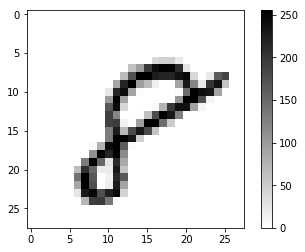

In [10]:
%matplotlib inline
import pylab as plt
plt.imshow(train_images[-1], interpolation="nearest", cmap="binary")
plt.colorbar()
plt.show()

In [11]:
len(train_labels)

60000

In [12]:
train_labels

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Let's have a look at the test data:

In [13]:
test_images.shape

(10000, 28, 28)

In [14]:
len(test_labels)

10000

In [15]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Our workflow will be as follow: first we will present our neural network with the training data, `train_images` and `train_labels`. The 
network will then learn to associate images and labels. Finally, we will ask the network to produce predictions for `test_images`, and we 
will verify if these predictions match the labels from `test_labels`.

Let's build our network

In [16]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))


The core building block of neural networks is the "layer", a data-processing module which you can conceive as a "filter" for data. Some 
data comes in, and comes out in a more useful form. Precisely, layers extract _representations_ out of the data fed into them -- hopefully 
representations that are more meaningful for the problem at hand. Most of deep learning really consists of chaining together simple layers 
which will implement a form of progressive "data distillation". A deep learning model is like a sieve for data processing, made of a 
succession of increasingly refined data filters -- the "layers".

Here our network consists of a sequence of two `Dense` layers, which are densely-connected (also called "fully-connected") neural layers. 
The second (and last) layer is a 10-way "softmax" layer, which means it will return an array of 10 probability scores (summing to 1). Each 
score will be the probability that the current digit image belongs to one of our 10 digit classes.

To make our network ready for training, we need to pick three more things, as part of "compilation" step:

* A loss function: the is how the network will be able to measure how good a job it is doing on its training data, and thus how it will be 
able to steer itself in the right direction.
* An optimizer: this is the mechanism through which the network will update itself based on the data it sees and its loss function (basically variations of grading descent).
* Metrics to monitor during training and testing. Here we will only care about accuracy (the fraction of the images that were correctly 
classified).

In [17]:
network.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=['accuracy'])

Make sure that you understand how the following figure fits with the network architecture you have created in the code snippets above:

![](./images/dl.png)


Before training, we will preprocess our data by reshaping it into the shape that the network expects, and scaling it so that all values are in 
the `[0, 1]` interval. Previously, our training images for instance were stored in an array of shape `(60000, 28, 28)` of type `uint8` with 
values in the `[0, 255]` interval. We transform it into a `float32` array of shape `(60000, 28 * 28)` with values between 0 and 1.

In [18]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

We also need to categorically encode the labels, a step which we will explain in detail in future Practicals:

In [19]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

We are now ready to train our network, which in Keras is done via a call to the `fit` method of the network: 
we "fit" the model to its training data.

In [20]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.2519 - acc: 0.9279
Epoch 2/5
60000/60000 [==============================] - 5s 90us/step - loss: 0.1024 - acc: 0.9696
Epoch 3/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0665 - acc: 0.9797
Epoch 4/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0486 - acc: 0.9853
Epoch 5/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0369 - acc: 0.9891


Two quantities are being displayed during training: the "loss" of the network over the training data, and the accuracy of the network over 
the training data.

We quickly reach an accuracy of 0.989 (i.e. 98.9%) on the training data. Now let's check that our model performs well on the test set too:

In [21]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 69us/step


In [22]:
print('test_acc:', test_acc)

test_acc: 0.98



Our test set accuracy turns out to be 98% -- that's a bit lower than the training set accuracy. 
This gap between training accuracy and test accuracy is an example of "overfitting", 
the fact that machine learning models tend to perform worse on new data than on their training data. 

This concludes our very first example -- you just saw how we could build and a train a neural network to classify handwritten digits, in less than 20 lines of Python code. 